<a href="https://colab.research.google.com/github/124shlomis/ML_COURSE/blob/master/HW3_PCA_1NN_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework assignment 3 - Classification

In this assignment, we will use the K-NN and LDA methods for face recognition.

We will use PCA for generating features for our classifiers.

## Reminders

- Start by making a copy of this notebook in order to be able to save it.
- Use **Ctrl+[** to expend all cells.

## Tip of the day - Displaying functions documentation

You can quickly display a function's documentation by pressing **Alt+/** when standing on it with the cursor.

You can also open a small documentation window at the bottom of the screen by running a command for the format of **?{function}** in a new cell (and replacing **{function}** with your function's name.

Try opening a new cell, bellow this one by clicking on the **+code** button below the menu bar. Then type:
```python
?print
```
into it and run it.

You would need to use the functions' full call string. For example, to view the documentation of the **randint** function in the numpy package, you will have to run *?np.random.randint*. You can, of course, only view the documentation for this function after importing the numpy library (i.e., after running *import numpy as np*)

In [0]:
?print

## Your IDs

✍️ Fill in your IDs in the cell below:

In [239]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
# Replace the IDs bellow with our own
student1_id = ''
student2_id = ''
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

print('Hello ' + student1_id + ' & ' + student2_id)

Hello  & 


### Importing Packages

Importing the NumPy, Pandas and Matplotlib packages.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Labeled faces in the wild

For this task, we will use a dataset called [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/), which contains 13233 images of faces which belong to  5749 people. Each image in the dataset is labeled with a number corresponding to a person's name. All the images in the dataset are cropped and resized to the same image size.

To load the data, we will use the scikit-learn's function [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html). To make our life a bit easier we will only use faces of people which appear in the dataset more than 50 times. We can do so using the function's **min_faces_per_person** argument. 

Number of images in the dataset: 1560
Number of different persons in the dataset: 12
Each images size is: (62, 47)


Text(0, 0.5, 'Number of images')

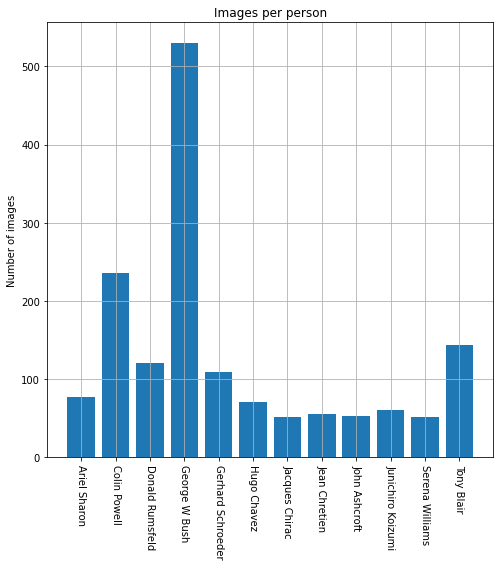

In [220]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=50)

x = dataset.images
y = dataset.target
label_to_name_mapping = dataset.target_names
image_shape = x[0].shape

print('Number of images in the dataset: {}'.format(len(x)))
print('Number of different persons in the dataset: {}'.format(len(np.unique(y))))
print('Each images size is: {}'.format(image_shape))

_, images_per_class = np.unique(y, return_counts=True)
fig, ax = plt.subplots()
ax.bar(label_to_name_mapping, images_per_class)
ax.set_xticklabels(label_to_name_mapping, rotation=-90);
ax.set_title('Images per person')
ax.set_ylabel('Number of images')

The following code plots the first 20 images in the dataset. 

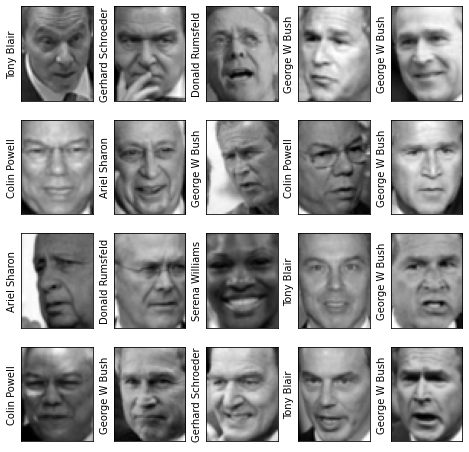

In [221]:
fig, ax_array = plt.subplots(4, 5)
for i, ax in enumerate(ax_array.flat):
    ax.imshow(x[i], cmap='gray')
    ax.set_ylabel(label_to_name_mapping[y[i]])
    ax.set_yticks([])
    ax.set_xticks([])

## The task

Our task here is to be able to predict the correct label (name of the person) given an image of his face. Formally, we would like to find a classifier $h\left(\boldsymbol{x}\right)$, which would minimize the misclassification rate:
$$
R\left\{h\right\}=E\left[I\left\{h\left(\boldsymbol{x}\right)\neq y\right\}\right]
$$

Here $\boldsymbol{x}$ is the measured data, which is in our case the images, and $y$ is the label of the image.

## 📚 Splitting the Data

✍️ Complete the code below to split the data into 80% train set and 20% test set


In [222]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Split the indices into 80% train / 20% test

## Create a random generator using a fixed seed
rand_gen = np.random.RandomState(0)
n_samples = len(x)
indices = np.arange(0,n_samples)
rand_gen.shuffle(indices)

n_samples_train = int(n_samples * 0.8)
n_samples_test = n_samples - n_samples_train
train_indices = indices[0:n_samples_train] ## Assign the first n_samples_train values of the indices array to train_indices
test_indices = indices[n_samples_train:] ## Assign the last n_samples_test values of the indices array to test_indices

x_train = x[train_indices]
x_test = x[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%%%

print('Number of training sample: {}'.format(n_samples_train))
print('Number of test sample: {}'.format(n_samples_test))

Number of training sample: 1248
Number of test sample: 312


## PCA for compression feature selection

Instead of working directly with the pixels as our input, we would like to select a smaller number of features to use as an input to our classifier.

We will use PCA to represent a given image using a smaller number of variables. 

We can also think of this task as trying to compress the image representation.

Currently, each image is represented using 2914 numbers (47 x 62 pixels). Let us try to reduce this number using PCA. This, of course, will come at the cost of not being able to reconstruct the image exactly, but only approximately.

## Reshaping the data

In order to use PCA on the images need to store each image as a vector. We will reshape each image to be a 1d vector of size 2914 x 1.

In [0]:
x_flat_train = x_train.reshape(len(x_train), -1) ## Reshape the training data to (n_smaples_train x 2914)
x_flat_test = x_test.reshape(len(x_test), -1)

## Removing the mean value

We will start by calculating the data's mean and remove it form the data.

**Note**: Another common practice before performing PCA is to normalize the data by dividing by the standard deviation of the data. This is mainly important for datasets which include multiple types of data which can even be measured in different units. In our case all the values feed into the PCA are pixels with values between 0 and 255, therefore this normalization is less needed in this case and can even be harmful.  

✍️ Complete the code below to compute and remove the data's mean.

- Complete the mean using the train set .

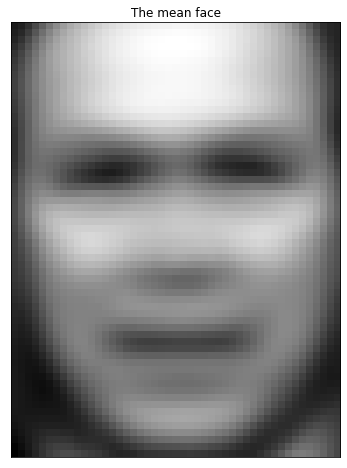

In [224]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
mean_x = np.mean(x_flat_train,0)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%

## Ploting the mean images
mean_image = mean_x.reshape(image_shape)
fig, ax = plt.subplots()
ax.imshow(mean_image, cmap='gray')
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('The mean face');

### Calculating the PCA basis

✍️ Complete the code below to compute the basis vectors of PCA.

- Implement PCA using the matrix product operator, **A @ B**, and the function [numpy.linalg.eig](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) which calucates the eigen-values and eigen-vectors of a matrix:
```python
D, V = np.linalg.eig(A)
```
where **D** is the 1D array of the eign-values and **V** is the unitary matrix of the eigen-vectors. **A = V @ np.diag(D) @ V.T**

- Do not use any function which implements PCA directly.
- Remember to subtract the mean value

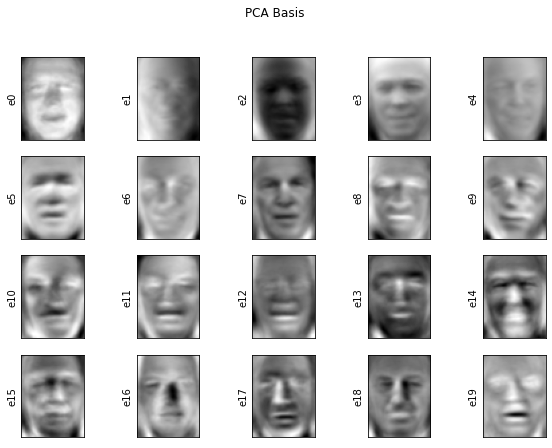

In [225]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
x_flat_train_meaned = x_flat_train - mean_x
P_train = (1 / n_samples_train) * (np.transpose(x_flat_train_meaned) @ x_flat_train_meaned)
D , V = np.linalg.eig(P_train)


basis = V  # The PCA basis. this should be a (2914 x 2914) matrix with a basis vector on each column.
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%

## plot the first 20 PCA basis vectors
fig, ax_array = plt.subplots(4, 5, figsize=(10,7))
for i, ax in enumerate(ax_array.flat):
    img = basis[:, i].reshape(*image_shape)  ## Reshaping the basis vectors bask to images
    ax.imshow(img, cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('e{}'.format(i))
fig.suptitle('PCA Basis');

Make sure that you get something that  roughly resembles faces in the figure above.

### Calculating the PCA components

✍️ Complete the function below which calculates the first n_components of a given image using the calculated basis.

In [226]:
def calc_principal_components(img, basis, mean_x, n_components):
    """
    Reconstruct an image from it's principal componants given a basis.

    Using:
    - D: the dimension of the original space (number of pixels).
    - H: the images' height
    - W: the images' width
   
    Parameters
    ----------
    img: ndarray
        The HxW 2D array of the input image.
    basis: ndarray
        The DxD 2D array of the PCA basis where each column is a basis vector.
    mean_x
        The 1D array of length (HxW) of the mean data value.
    n_components: int
        The number of principal components to return
    
    Returns
    -------
    components: ndarray
        The 1D array of length n_components of the principal components.
    """
    img_flat = img.flat
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    img_flat = img_flat - mean_x
    components = np.transpose((basis[:,:n_components])) @ img_flat
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    return components

print('The 10 principal components of the first test image are:\n{}'.format(list(calc_principal_components(x_test[0], basis, mean_x, 10))))

The 10 principal components of the first test image are:
[124.11133, 1421.0616, -282.34644, 19.8499, 681.5232, -279.04926, -255.27713, 134.43575, 297.9119, -23.780184]


## Reconstructing an image from its principal components

✍️ Fill in the function bellow which reconstructs an image from its principal components.

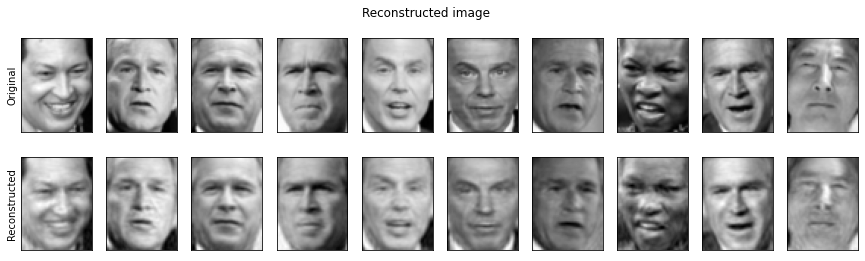

In [227]:
def reconstruct_image(components, basis, mean_x, image_shape):
    """
    Reconstruct an image from it's principal componants given a basis.

    Using:
    - N: number of components.
    - D: the dimension of the original space (number of pixels).
    - H: the images' height
    - W: the images' width
   
    Parameters
    ----------
    components: ndarray
        The 1D array of length D of the image's components.
    basis: ndarray
        The DxD 2D array of the PCA basis where each column is a basis vector.
    mean_x
        The 1D array of length (HxW) of the mean data value.
    image_shape: list
        The list: [image_hight, image_width]
    
    Returns
    -------
    img: ndarray
        The HxW 2D array of the reconstructed image.
    """

    n_components = len(components)
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    img_flat = (basis[:,:n_components] @ components) + mean_x
    img = np.reshape(img_flat,image_shape) 
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    return img

## Ploting the reconstruction of the first 10 test images
fig, ax_array = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    components = calc_principal_components(x_test[i], basis, mean_x, 300)
    reconstructed_image = reconstruct_image(components, basis, mean_x, image_shape)

    ax_array[0][i].imshow(x_test[i], cmap='gray')
    ax_array[0][i].set_yticks([])
    ax_array[0][i].set_xticks([])

    ax_array[1][i].imshow(reconstructed_image, cmap='gray')
    ax_array[1][i].set_yticks([])
    ax_array[1][i].set_xticks([])
ax_array[0][0].set_ylabel('Original')
ax_array[1][0].set_ylabel('Reconstructed')
fig.suptitle('Reconstructed image');

The code below plots the reconstructed image and error as a function of the number of components. 

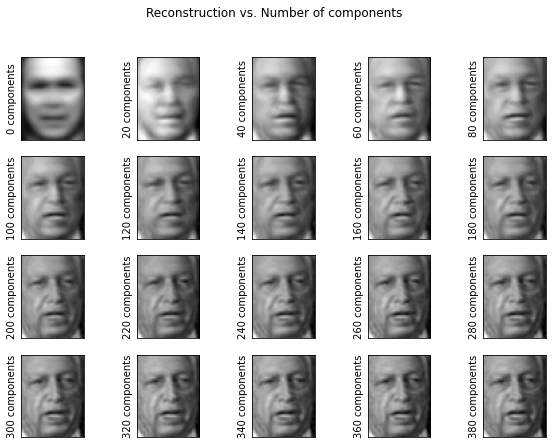

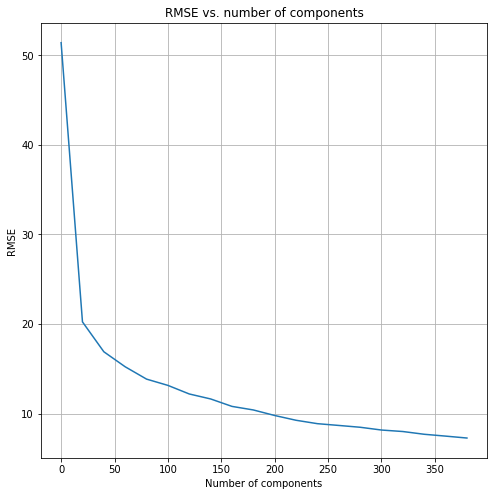

In [228]:
## For visualization, find the index of the first image of Ariel Sharon in the test set
ariel_sharon_index = np.argwhere(y_test == 0)[0, 0]

n_components_list = []
reconstruction_error_list = []

fig, ax_array = plt.subplots(4, 5, figsize=(10,7))
for i, ax in enumerate(ax_array.flat):
    n_components = i * 20
    components = calc_principal_components(x_test[ariel_sharon_index], basis, mean_x, n_components)
    reconstructed_image = reconstruct_image(components, basis, mean_x, image_shape)
    
    reconstruction_error = ((reconstructed_image - x_test[ariel_sharon_index]) ** 2).mean() ** 0.5
    reconstruction_error_list.append(reconstruction_error)
    n_components_list.append(n_components)
    
    ax.imshow(reconstructed_image, cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('{} components'.format(n_components))
fig.suptitle('Reconstruction vs. Number of components')
    
fig, ax = plt.subplots()
ax.plot(n_components_list, reconstruction_error_list)
ax.set_title('RMSE vs. number of components')
ax.set_xlabel('Number of components')
ax.set_ylabel('RMSE');

From here on, we shall use 300 components.

## sklearn.decomposition.PCA

From here on we will use the [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to perform PCA.

✍️ Read the function's documentation and complete the following code to run PCA using scikit-learn's class. Calculate the basis, the test image's components, and the reconstruction of the test images.

- Note that the basis is only define up to a $\pm$ sign there the basis can have a different sign then the ones calculated above.

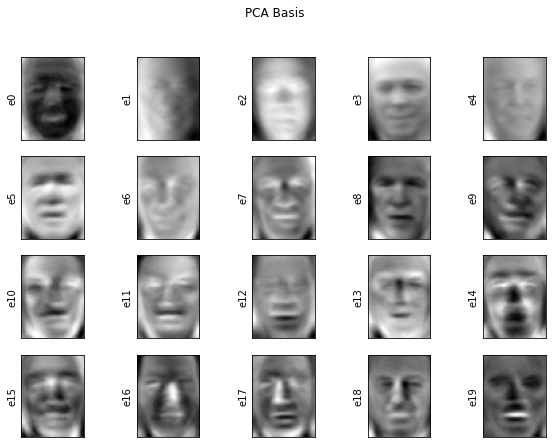

In [229]:
from sklearn.decomposition import PCA
n_components = 300
pca = PCA(n_components)

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Calculate the PCA basis
pca.fit(x_flat_train)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## plot first 20 PCA basis vectors
fig, ax_array = plt.subplots(4, 5, figsize=(10,7))
for i, ax in enumerate(ax_array.flat):
    img = pca.components_[i].reshape(*image_shape)
    ax.imshow(img, cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('e{}'.format(i))
fig.suptitle('PCA Basis');

In [230]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Calculate the componantes of all the test images.
components = pca.transform(x_flat_test)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

print('The 10 principal components of the first test image are:\n{}'.format(list(components[0, :10])))


The 10 principal components of the first test image are:
[-124.111275, 1421.0623, 282.3468, 19.853577, 681.52386, -279.04904, -255.27698, -134.43715, -297.91083, 23.782143]


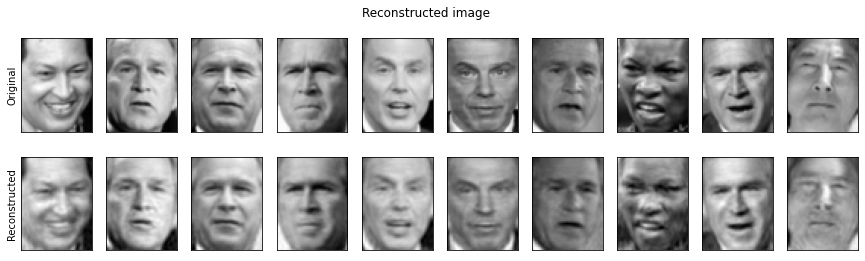

In [231]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Reconstruct all the test images form their componants.
reconstructed_images_flat = pca.inverse_transform(components)
reconstructed_images = reconstructed_images_flat.reshape(312,62,47)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## Ploting the reconstruction of the first 10 test images
fig, ax_array = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    ax_array[0][i].imshow(x_test[i], cmap='gray')
    ax_array[0][i].set_yticks([])
    ax_array[0][i].set_xticks([])

    ax_array[1][i].imshow(reconstructed_images[i], cmap='gray')
    ax_array[1][i].set_yticks([])
    ax_array[1][i].set_xticks([])
ax_array[0][0].set_ylabel('Original')
ax_array[1][0].set_ylabel('Reconstructed')
fig.suptitle('Reconstructed image');

## 1-NN Classification

Lets us now try to classify the images using 1-nearest neighbor (1-NN). 

✍️ Complete the following code to implement the 1-NN classification.

- Use the [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) function, which we encountered in the last assignment, to calculate the matrix of all distances between two sets of vectors.

In [232]:
from scipy.spatial.distance import cdist

features_train = pca.transform(x_flat_train)
features_test = pca.transform(x_flat_test)

def one_nn(features, stored_features, stored_y):
    """
    Calculates the estimated labels for a given set of features using the 1-NN method. 

    Using:
    - N: the number of samples in the train set.
    - M: the number of samples for which the labels are to be estimated.
    - D: the length of the feature vectors.
   
    Parameters
    ----------
    features: ndarray
        The MxD 2D array of features for which the labels are to be estimated.
    stroed_features: ndarray
        The NxD 2D array of the features of the train set.
    stored_y: ndarray
        The 1D array of length N of the labels of the train set.
    
    Returns
    -------
    y_hat: ndarray
        The 1D array of length M of the estimated labels.
    """
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    distances = cdist(features_test,stored_features,'euclidean')
    min_distance_indecies = np.argmin(distances,axis=1)

    y_hat = stored_y[min_distance_indecies]
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    
    return y_hat

y_hat_test = one_nn(features_test, features_train, y_train)

empirical_risk_test = (y_hat_test != y_test).mean()

print('The empirical risk (amount of misclassifications) on the test set is: {}'.format(empirical_risk_test))

The empirical risk (amount of misclassifications) on the test set is: 0.4230769230769231


You should get an empirical risk of about $0.5\pm0.1$ on the test set. 

The following code displays the estimated labels of the first 20 faces in the test set.

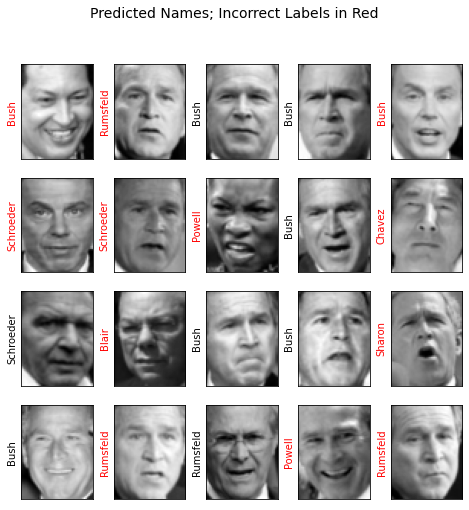

In [233]:
## Plot estimation
fig, ax_array = plt.subplots(4, 5)
for i, ax in enumerate(ax_array.flat):
    ax.imshow(x_test[i], cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(label_to_name_mapping[y_hat_test[i]].split()[-1],
                   color='black' if y_hat_test[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

## sklearn.neighbors.KNeighborsClassifier

The class [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) implements the K-NN algorithm.

✍️ Read the function's documentation and fill in the following code run 1-NN using scikit-learn's class. 

In [234]:
from sklearn.neighbors import KNeighborsClassifier

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(features_train,y_train)

y_hat_test = classifier.predict(features_test)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

empirical_risk_test = (y_hat_test != y_test).mean()

print('The empirical risk (amount of misclassifications) on the test set is: {}'.format(empirical_risk_test))


The empirical risk (amount of misclassifications) on the test set is: 0.4230769230769231


## LDA

Let us now evaluate the linear discrimination analysis (LDA) method.

## Learning

First, we will estimate the model's parameters. 

✍️ Fill in the code below to calculate the model's parameters using MLE.

Reminder, LDA's model parameters are:
- The mean values for each class
- The covariance matrix for all classes.
- The prior distribution of each class.

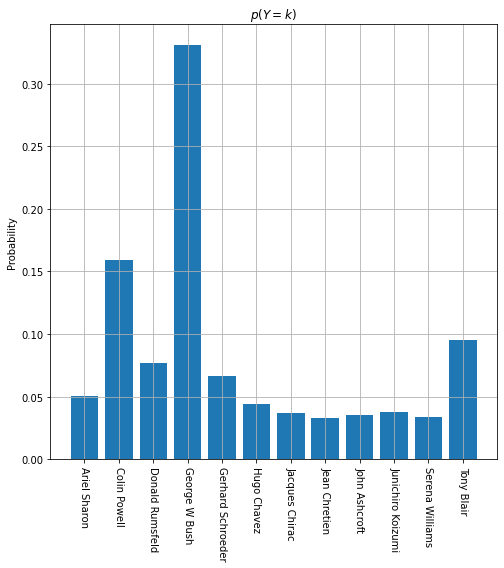

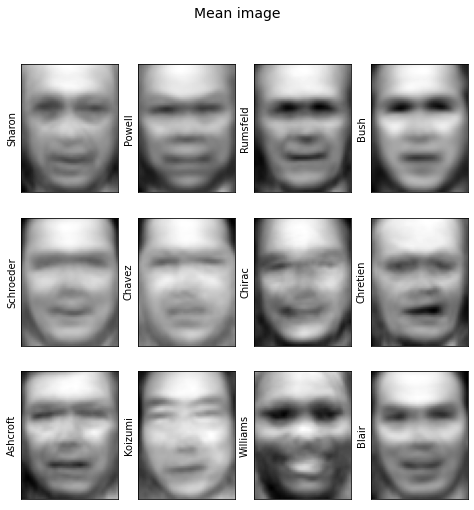

In [238]:
def calc_lda_parameters(features, y):
    """
    Calculates the parameters of the LDA model. 

    Using:
    - N: the number of samples in the train set.
    - D: the length of the feature vectors.
    - K: the number of classes.
   
    Parameters
    ----------
    features: ndarray
        The NxD 2D array of features the train set.
    y: ndarray
        The 1D array of length N of the labels of the train set.
    
    Returns
    -------
    py: ndarray
        The 1D array of length K of the prior probability of each class: P(Y=k).
    mu: ndarray:
        The KxD array of the K means of each classes distribution.
    cov_mat: ndarray:
        The DxD array of the covariance matrix of the classes distribution.
    """
    n_classes = np.max(y) + 1
    N = len(y)
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    py = np.zeros(n_classes)
    mu = np.zeros([n_classes,features.shape[1]])
    cov_mat_sum = np.zeros([features.shape[1],features.shape[1]])

    for i in range(n_classes):
      abs_G_i = sum(y == i)
      py[i] = abs_G_i / N
      indices_i = np.where(y == i)
      x_belongs_i = np.squeeze(features[indices_i,:])
      sum_of_x_belongs_i= np.sum(x_belongs_i,axis=0)
      mu[i] = sum_of_x_belongs_i / abs_G_i
      cov_mat_sum = cov_mat_sum + np.transpose((x_belongs_i - mu[i])) @ (x_belongs_i - mu[i])
    
    cov_mat = cov_mat_sum / N 
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    
    return py, mu, cov_mat


py, mu, cov_mat = calc_lda_parameters(features_train, y_train)

## Plot P(y)
fig, ax = plt.subplots()
ax.bar(label_to_name_mapping, py)
ax.set_xticklabels(label_to_name_mapping, rotation=-90);
ax.set_title('$p\\left(Y=k\\right)$')
ax.set_ylabel('Probability')

## Display the means
fig, ax_array = plt.subplots(3, 4)
for i, ax in enumerate(ax_array.flat):
    img_flat = pca.inverse_transform(mu[i][None, :])[0]
    img = img_flat.reshape(image_shape)
    ax.imshow(img, cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(label_to_name_mapping[i].split()[-1])
fig.suptitle('Mean image', size=14);

### Classifying

Now we can use the estimated parameters to build our classifier.

Reminder: in the case of multiple classes the classification of the LDA model is given by:

$$
h\left(\boldsymbol{x}\right)=\underset{k}{\arg\max}\ p\left(\boldsymbol{x}|Y=k\right)p\left(Y=k\right)
$$

The argmax in solved simply be testing all $k$'s.

✍️  Complete the following code to implement the classification function:

- *Optional*: The term $\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^T\Sigma^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)$, which appears in $p\left(\boldsymbol{x}|y\right)$, is called the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) between $\boldsymbol{x}$ and $\boldsymbol{\mu}$ based on the covariance matrix $\Sigma$. You can use the **cdist** function to calculate all the Mahalanobis distances between a set of $\boldsymbol{x}$'s and a set of $\boldsymbol{\mu}$'s. This can be done using the **'mahalanobis'** metric and adding a **VI = $\Sigma^{-1}$** arguments to the **cdist** function.

The empirical risk (amount of missclassifications) on the test set is: 0.14423076923076922


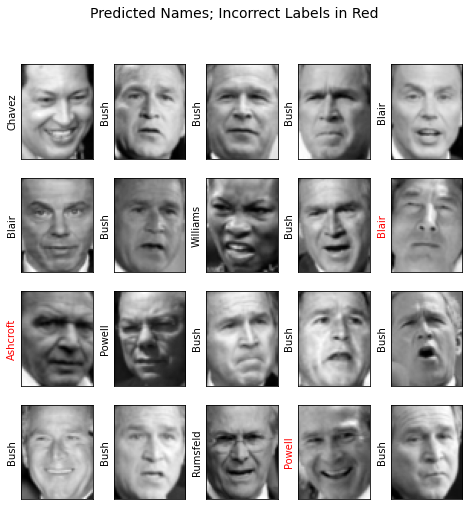

In [236]:
def lda_classify(features, py, mu, cov_mat):
    """
    Calculates the parameters of the LDA model. 

    Using:
    - N: the number of samples in the train set.
    - D: the length of the feature vectors.
    - K: the number of classes.
   
    Parameters
    ----------
    features: ndarray
        The NxD 2D array of features for which the labels are to be estimated.
    py: ndarray
        The 1D array of length K of the prior probability of each class: P(Y=k).
    mu: ndarray:
        The KxD array of the K means of each classes distribution.
    cov_mat: ndarray:
        The DxD array of the covariance matrix of the classes distribution.
    
    Returns
    -------
    y_hat: ndarray
        The 1D array of length N of the estimated labels.
    """
    
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    mahalanobis_term = cdist(features, mu, metric='mahalanobis', VI=np.linalg.inv(cov_mat)) ** 2
    y_hat = np.argmin(np.add(mahalanobis_term,np.log(py)),axis=1)
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    
    return y_hat

y_hat_test = lda_classify(features_test, py, mu, cov_mat)

empirical_risk_test = (y_hat_test != y_test).mean()

print('The empirical risk (amount of missclassifications) on the test set is: {}'.format(empirical_risk_test))

## Plot estimation
fig, ax_array = plt.subplots(4, 5)
for i, ax in enumerate(ax_array.flat):
    ax.imshow(x_test[i], cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(label_to_name_mapping[y_hat_test[i]].split()[-1],
                   color='black' if y_hat_test[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

## sklearn.discriminant_analysis.LinearDiscriminantAnalysis

The class [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) implements the LDA algorithm.

✍️ Read the function's documentation and fill in the following code run LDA using scikit-learn's class. 

In [237]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
clf = LinearDiscriminantAnalysis()
clf.fit(features_train, y_train)
y_hat_test = clf.predict(features_test)
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

empirical_risk_test = (y_hat_test != y_test).mean()

print('The empirical risk (amount of misclassifications) on the test set is: {}'.format(empirical_risk_test))

The empirical risk (amount of misclassifications) on the test set is: 0.15384615384615385


## Reminder: Submission

To submit your code, download it as a **ipynb** file from Colab, and upload it to the course's website. You can download this code by selecting **Download .ipynb** from the **file** menu.